# Basic Walk-Through: k-nearest Neighbors

This notebook contains several examples that illustrate the machine learning workflow using a dataset of house prices.

We will use the fairly straightforward [k-nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) (KNN) algorithm that allows us to tackle both regression and classification problems.

In its default sklearn implementation, it identifies the k nearest data points (based on the Euclidean distance) to make a prediction. It predicts the most frequent class among the neighbors or the average outcome in the classification or regression case, respectively.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

In [3]:
sns.set_style('whitegrid')

## Get the Data

### Kings County Housing Data

Data from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction)

Download via API:

```kaggle datasets download -d harlfoxem/housesalesprediction```

In [4]:
DATA_PATH = Path('..', 'data')

In [5]:
house_sales = pd.read_csv('kc_house_data.csv')
house_sales = house_sales.drop(
    ['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


## Select & Transform Features

### Asset Prices often have long tails

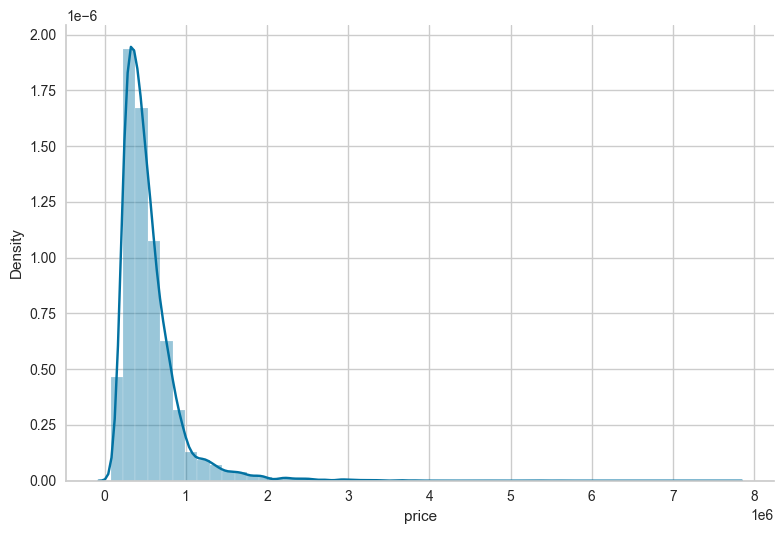

In [6]:
sns.distplot(house_sales.price)
sns.despine()
plt.tight_layout();

### Use log-transform

Useful for dealing with [skewed data](http://onlinestatbook.com/2/transformations/log.html).

In [7]:
X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales.price)

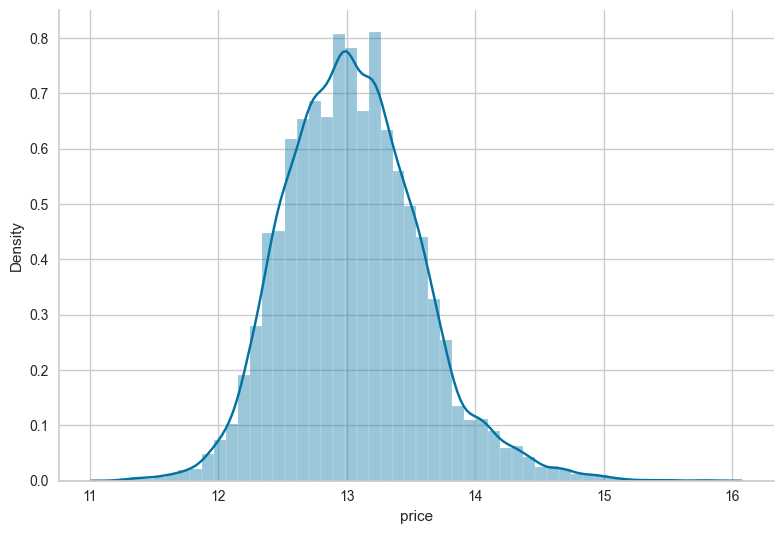

In [8]:
sns.distplot(y)
sns.despine()
plt.tight_layout();

### Mutual information regression

See sklearn [docs](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Covered later in Chapter 6 of the book.

In [9]:
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg

sqft_living      0.346247
grade            0.343430
sqft_living15    0.268164
sqft_above       0.261037
bathrooms        0.208424
sqft_lot15       0.085200
bedrooms         0.084750
yr_built         0.078107
floors           0.071955
sqft_basement    0.071188
sqft_lot         0.061743
view             0.058013
condition        0.018028
waterfront       0.013720
yr_renovated     0.008402
dtype: float64

In [10]:
print(mi_reg.iloc[:10])

sqft_living      0.346247
grade            0.343430
sqft_living15    0.268164
sqft_above       0.261037
bathrooms        0.208424
sqft_lot15       0.085200
bedrooms         0.084750
yr_built         0.078107
floors           0.071955
sqft_basement    0.071188
dtype: float64


In [11]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

### Bivariate Scatter Plots

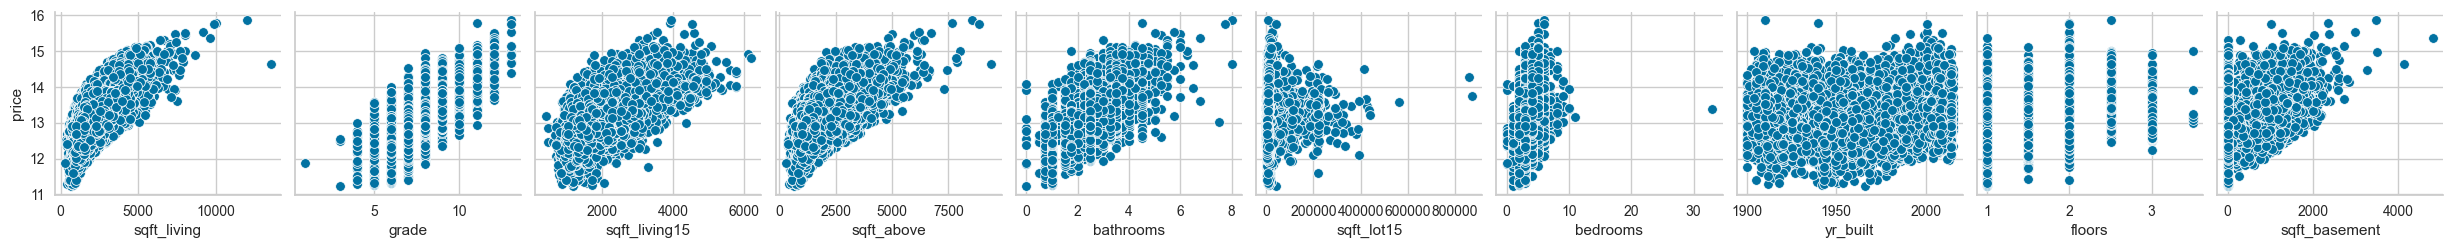

In [12]:
g = sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns)
sns.despine();

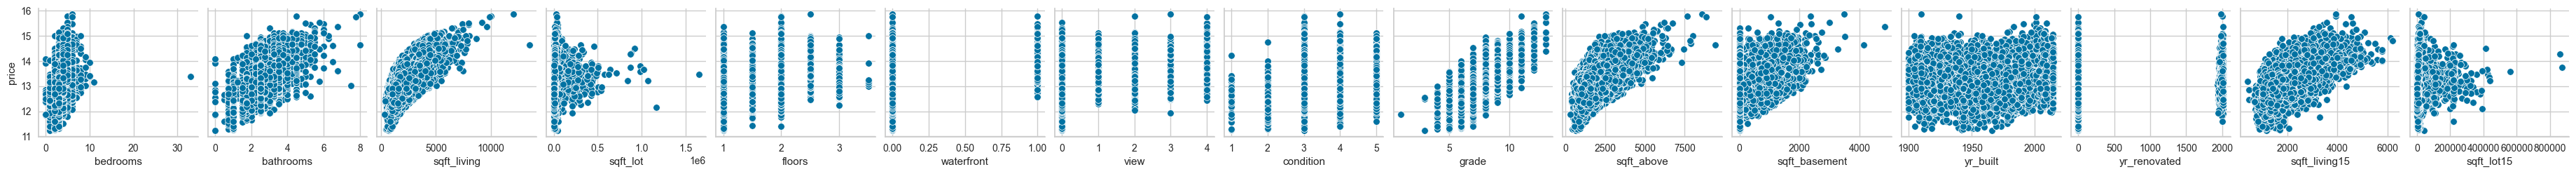

In [13]:
sns.pairplot(X_all.assign(price=y), y_vars=['price'], x_vars=X_all.columns)
sns.despine();

### Explore Correlations

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    21613 non-null  int64  
 1   grade          21613 non-null  int64  
 2   sqft_living15  21613 non-null  int64  
 3   sqft_above     21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_lot15     21613 non-null  int64  
 6   bedrooms       21613 non-null  int64  
 7   yr_built       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   sqft_basement  21613 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.6 MB


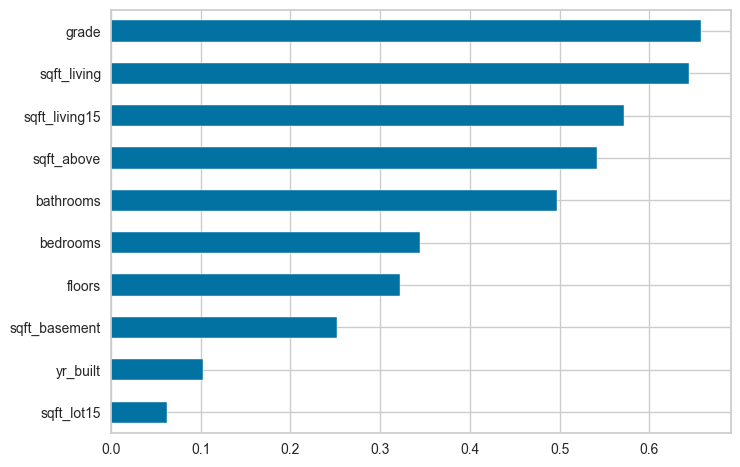

In [15]:
# y being np.log(house_sales.price)
correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();

In [16]:
ss = spearmanr(X, X)[0]

<Axes: >

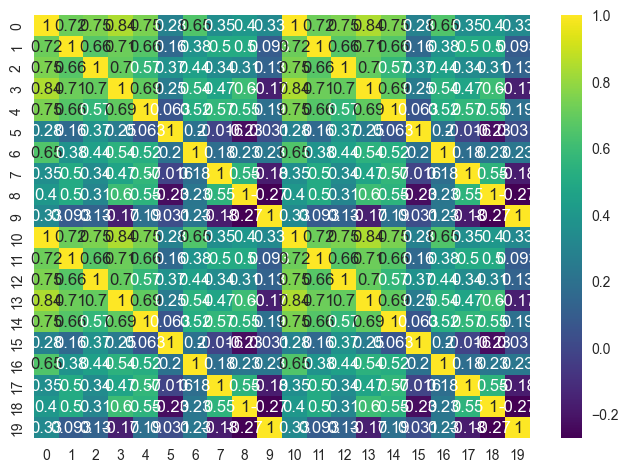

In [17]:
sns.heatmap(ss, annot=True, cmap='viridis')

## KNN Regression

### In-sample performance with default settings

KNN uses distance to make predictions; it requires standardization of variables to avoid undue influence based on scale

In [18]:
X_scaled = scale(X)

In [19]:
X

,sqft_living,grade,sqft_living15,sqft_above,bathrooms,sqft_lot15,bedrooms,yr_built,floors,sqft_basement
0,1180,7,1340,1180,1.00,5650,3,1955,1.0,0
1,2570,7,1690,2170,2.25,7639,3,1951,2.0,400
2,770,6,2720,770,1.00,8062,2,1933,1.0,0
3,1960,7,1360,1050,3.00,5000,4,1965,1.0,910
4,1680,8,1800,1680,2.00,7503,3,1987,1.0,0
...,...,...,...,...,...,...,...,...,...,...
21608,1530,8,1530,1530,2.50,1509,3,2009,3.0,0
21609,2310,8,1830,2310,2.50,7200,4,2014,2.0,0
21610,1020,7,1020,1020,0.75,2007,2,2009,2.0,0
21611,1600,8,1410,1600,2.50,1287,3,2004,2.0,0


In [20]:
X_scaled[:, 9]

array([-0.65868104,  0.2451414 , -0.65868104, ..., -0.65868104,
       -0.65868104, -0.65868104])

In [21]:
model = KNeighborsRegressor()
model.fit(X=X_scaled, y=y)

KNeighborsRegressor()

In [22]:
y_pred = model.predict(X_scaled)

### Regression Error Metrics

In [23]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

#### Computing the prediction error

The error is the deviation from the true value, whereas a residual is the deviation from an estimated value, e.g., an estimate of the population mean.

In [24]:
error = (y - y_pred).rename('Prediction Errors')

In [25]:
error.shape

(21613,)

In [26]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

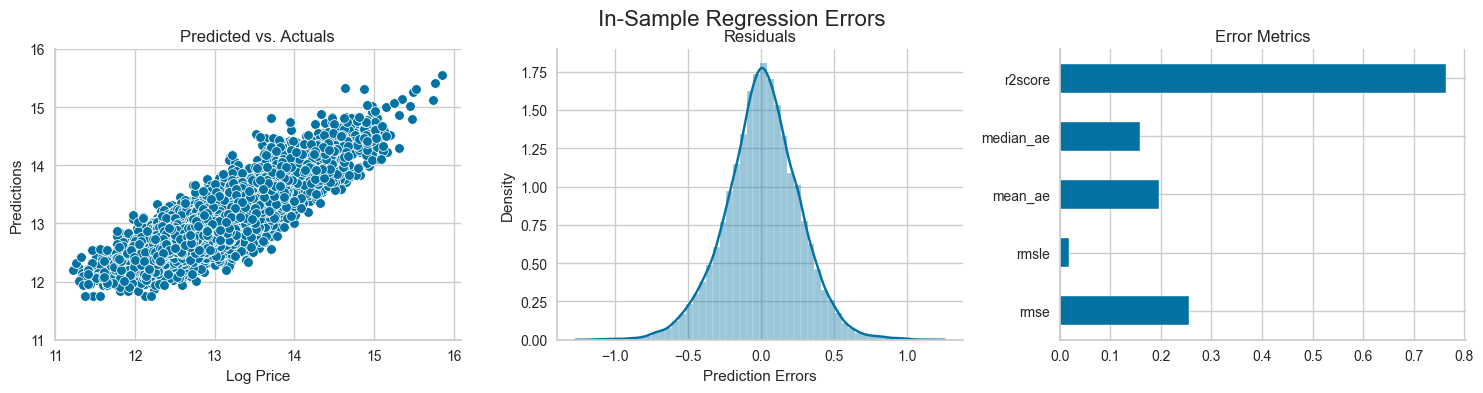

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)

### Cross-Validation

Manual hyperparameter tuning; using [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators) ensures proper scaling for each fold using train metrics to standardize test data.

In [28]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

rmse_score = make_scorer(rmse)

In [91]:
cv_rmse = {}
cv_pred = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=n))])                    
    cv_rmse[n] = cross_val_score(pipe, 
                                X=X, 
                                y=y,
                                scoring=rmse_score,
                                cv=5)
    cv_pred[n] = cross_val_predict(pipe, X=X, y=y, cv=5)
    

In [94]:
cv_rmse[5].shape

(5,)

In [95]:
cv_pred[5].shape

(21613,)

In [96]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns =['n', 'fold', 'RMSE']

In [97]:
cv_rmse

,n,fold,RMSE
0,1,0,0.397418
1,1,1,0.403705
2,1,2,0.405542
3,1,3,0.410658
4,1,4,0.383245
5,5,0,0.323529
6,5,1,0.324468
7,5,2,0.314509
8,5,3,0.325637
9,5,4,0.304039


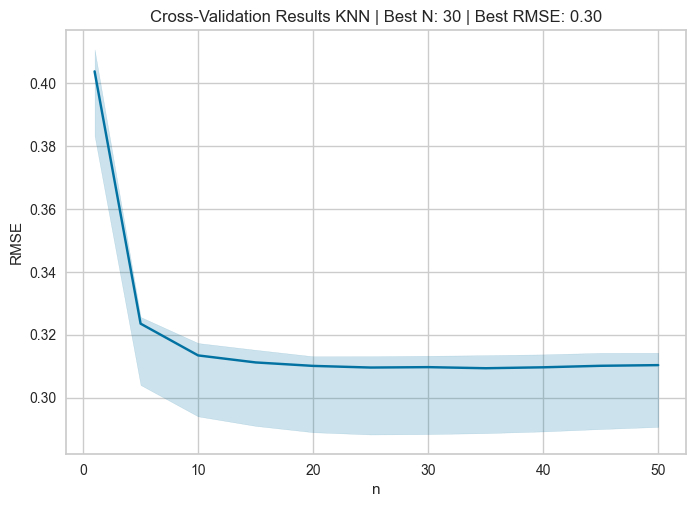

In [98]:
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse, estimator="median")
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}');

#### Actuals vs Predicted

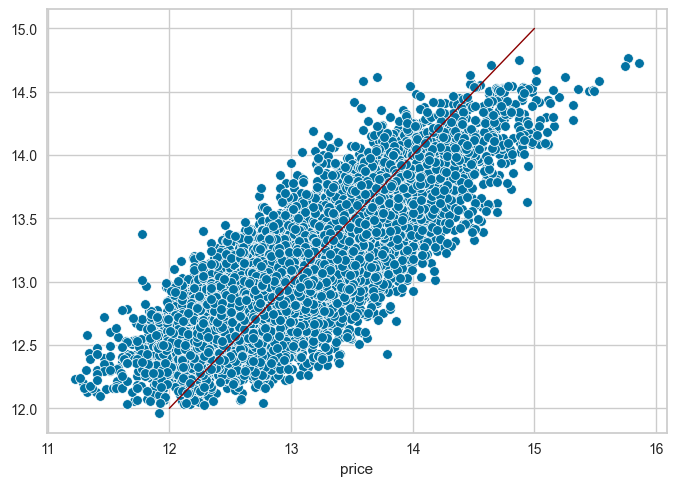

In [102]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])
y_pred = cross_val_predict(pipe, X, y, cv=5)

ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=1, c='darkred');

In [103]:
y_pred.shape

(21613,)

#### Cross-Validation Errors

In [104]:
error = (y - y_pred).rename('Prediction Errors')

In [105]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

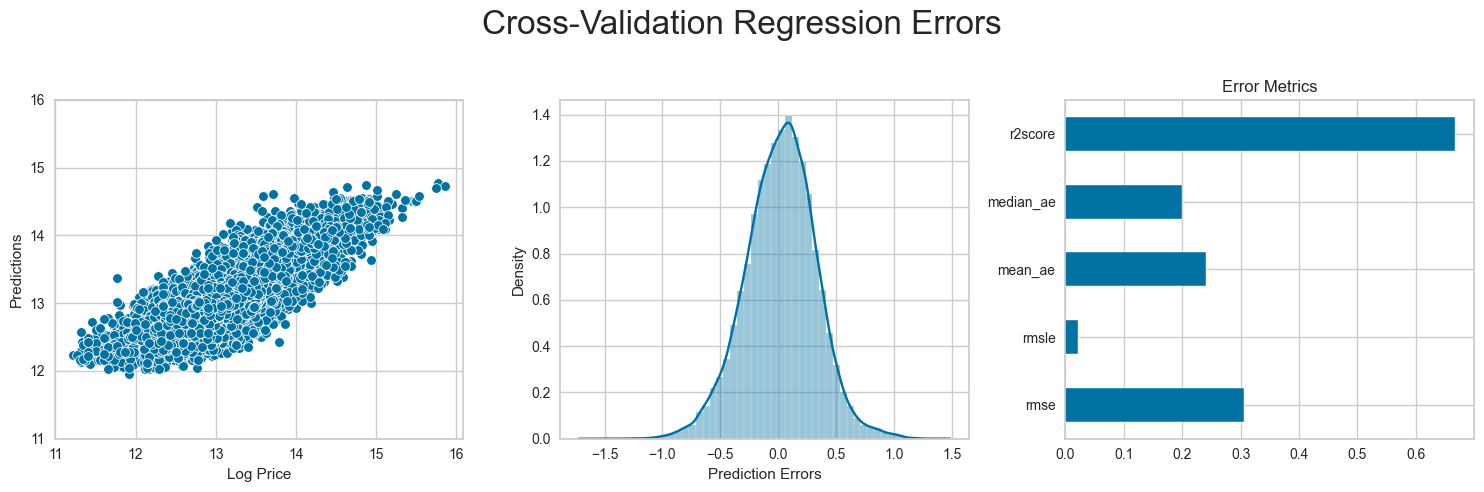

In [106]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8);

<Axes: xlabel='Prediction Errors', ylabel='Count'>

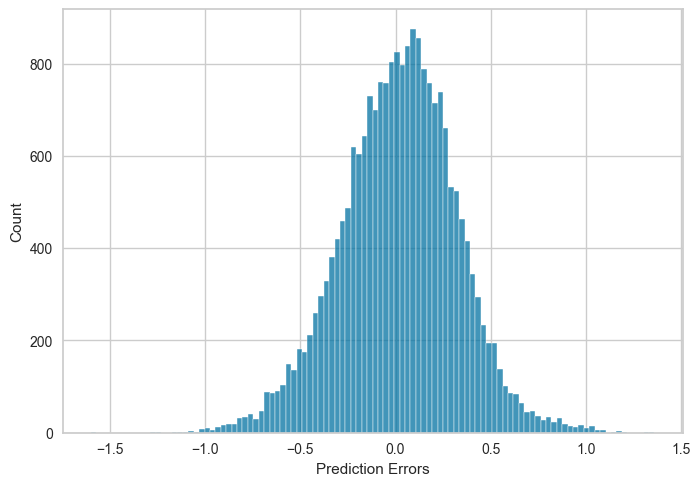

In [107]:
sns.histplot(error)

### GridSearchCV with Pipeline

See sklearn [docs](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator).


In [108]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse))

In [109]:
cv_results = estimator.cv_results_

In [111]:
test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)}, 
                           index=n_neighbors).stack().reset_index()
test_scores.columns = ['k', 'fold', 'RMSE']

In [112]:
mean_rmse = test_scores.groupby('k').RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

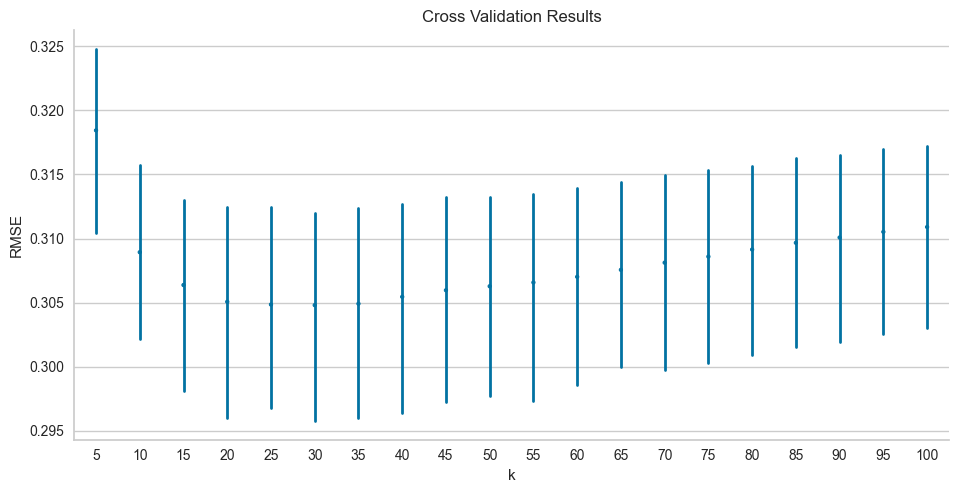

In [113]:
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
plt.title('Cross Validation Results')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);

### Train & Validation Curves mit yellowbricks


See background on [learning curves](https://en.wikipedia.org/wiki/Learning_curve) and yellowbrick [docs](https://www.scikit-yb.org/en/latest/).

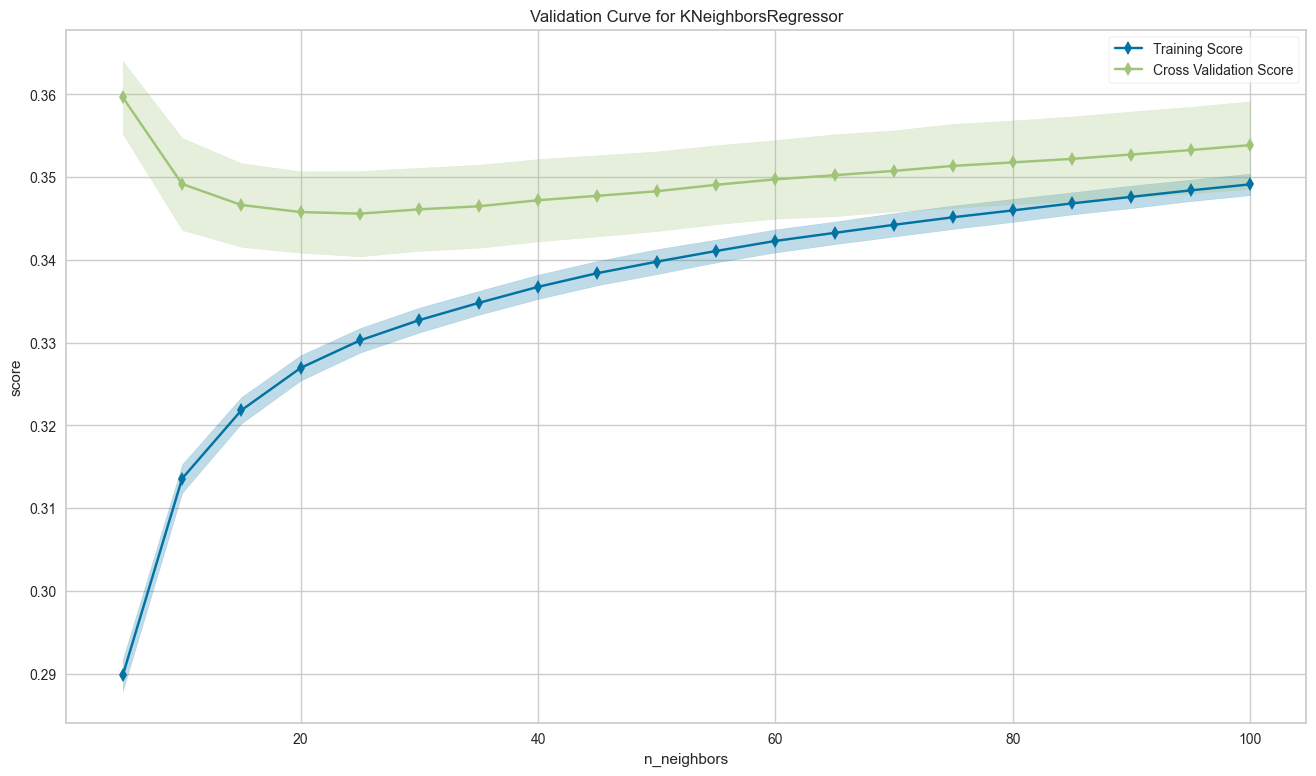

<Figure size 800x550 with 0 Axes>

In [114]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=5,
                      scoring=rmse_score,
#                       n_jobs=-1,
                      ax=ax)
val_curve.fit(X, y)
val_curve.poof()
sns.despine()
fig.tight_layout();

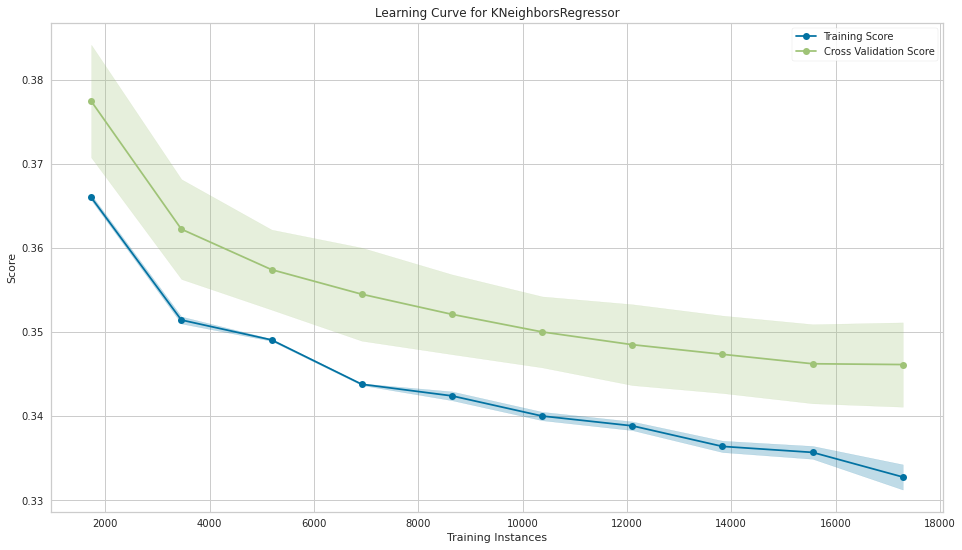

<Figure size 576x396 with 0 Axes>

In [34]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=rmse_score, 
                        cv=5, 
#                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y)
l_curve.poof()
sns.despine()
fig.tight_layout();

## Binary Classification

In [35]:
y_binary = (y>y.median()).astype(int)

In [36]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'roc_auc'

In [37]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=scoring,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y_binary)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)},
             scoring='roc_auc')

In [38]:
best_k = estimator.best_params_['knn__n_neighbors']

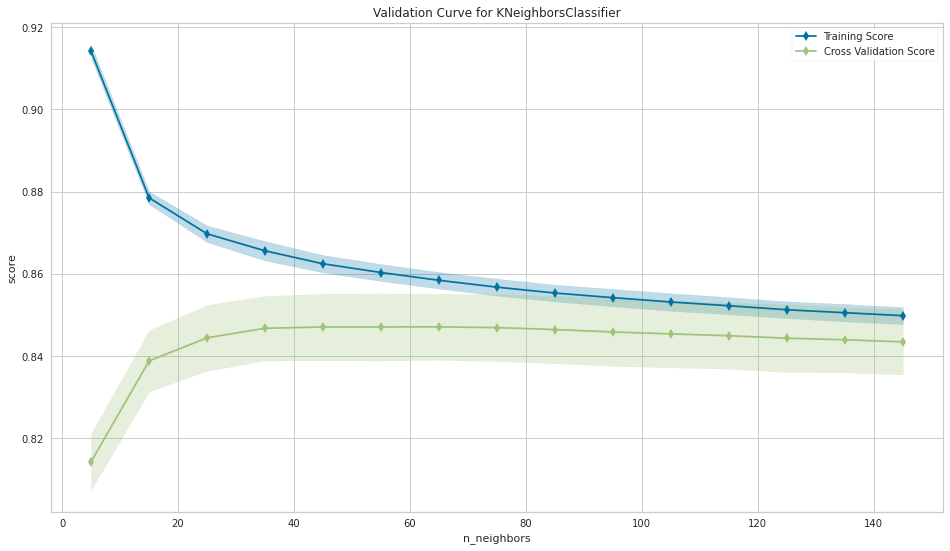

<Figure size 576x396 with 0 Axes>

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=n_folds,
                      scoring=scoring,
#                       n_jobs=-1,
                      ax=ax)
val_curve.fit(X, y_binary)
val_curve.poof()
sns.despine()
fig.tight_layout();

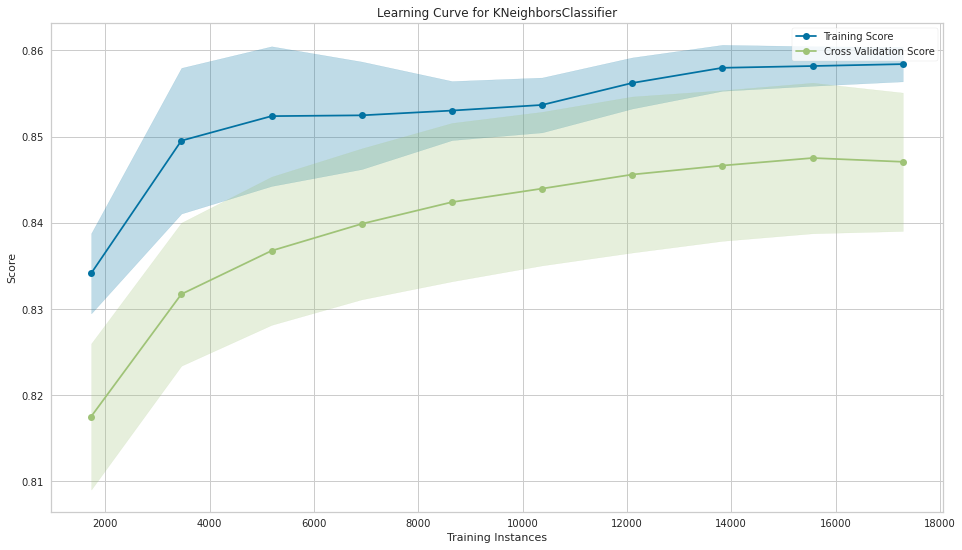

<Figure size 576x396 with 0 Axes>

In [40]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=scoring, 
                        cv=5, 
#                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y_binary)
l_curve.poof()
sns.despine()
fig.tight_layout();

### Classification Metrics

See sklearn [docs](https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation-quantifying-the-quality-of-predictions) for details.

In [41]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve)

|Name| API|
|:----|----|
|Area Under the Receiver Operating Characteristic Curve (ROC AUC) | roc_auc_score(y_true, y_score[, …])|
|Receiver operating characteristic (ROC) | roc_curve(y_true, y_score[, …])|
|Average precision (AP) | average_precision_score(y_true, y_score)|
|Precision-recall pairs | precision_recall_curve(y_true, …)|
|Precision, recall, F-measure and support | precision_recall_fscore_support(…)|
|F1 Score | f1_score(y_true, y_pred[, labels, …])|
|F-beta Score | fbeta_score(y_true, y_pred, beta[, …])|
|Precision | precision_score(y_true, y_pred[, …]|
|Recall | recall_score(y_true, y_pred[, …])|
|Main classification metrics | classification_report(y_true, y_pred)|
|confusion matrix | confusion_matrix(y_true, y_pred[, …])|
|Accuracy classification score | accuracy_score(y_true, y_pred)|
|Zero-one classification loss | zero_one_loss(y_true, y_pred[, …])|
|Average Hamming loss | hamming_loss(y_true, y_pred[, …])|
|Brier score | brier_score_loss(y_true, y_prob[, …])|
|Cohen’s kappa | cohen_kappa_score(y1, y2[, labels, …])|
|Average hinge loss | hinge_loss(y_true, pred_decision[, …])|
|Jaccard similarity coefficient | jaccard_similarity_score(y_true, y_pred)|
|Log loss, aka logistic loss or cross-entropy loss | log_loss(y_true, y_pred[, eps, …])|
|Matthews correlation coefficient (MCC) | matthews_corrcoef(y_true, y_pred[, …])|

In [42]:
y_score = cross_val_predict(KNeighborsClassifier(best_k), 
                           X=X, 
                           y=y_binary, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict_proba')[:, 1]

#### Using Predicted Probabilities

In [43]:
pred_scores = dict(y_true=y_binary,y_score=y_score)

##### ROC AUC

In [44]:
roc_auc_score(**pred_scores)

0.8460248502754856

In [45]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

##### Precision-Recall

In [46]:
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

##### F1 Score - Optimize Threshold

In [47]:
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()

##### Plot

In [48]:
roc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   False Positive Rate  67 non-null     float64
 1   True Positive Rate   67 non-null     float64
 2   threshold            67 non-null     float64
dtypes: float64(3)
memory usage: 1.7 KB


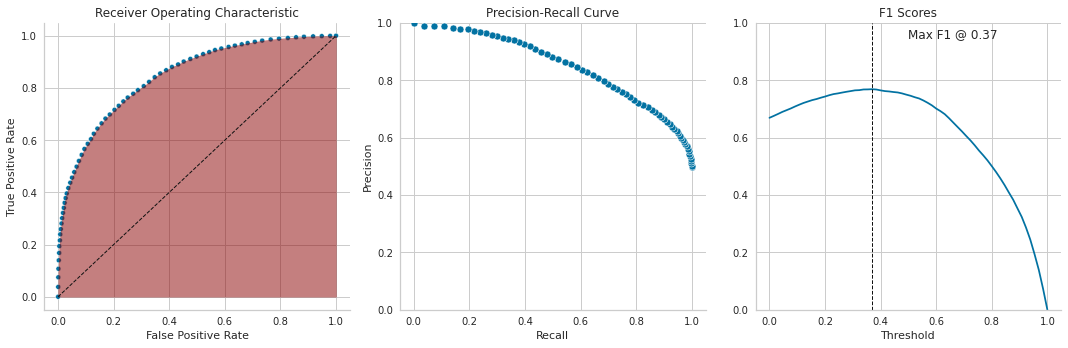

In [49]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();

##### Average Precision

In [50]:
average_precision_score(y_true=y_binary, y_score=y_score)

0.8484120767842546

##### Brier Score

In [51]:
brier_score_loss(y_true=y_binary, y_prob=y_score)

0.16022724653171427

#### Use Predictions after thresholding

In [52]:
y_pred = y_score > best_threshold

In [53]:
scores = dict(y_true=y_binary, y_pred=y_pred)

##### F-beta Score

In [54]:
fbeta_score(**scores, beta=1)

0.7684017044030412

In [55]:
print(classification_report(**scores))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71     10864
           1       0.70      0.86      0.77     10749

    accuracy                           0.74     21613
   macro avg       0.76      0.74      0.74     21613
weighted avg       0.76      0.74      0.74     21613



##### Confusion Matrix

In [56]:
confusion_matrix(**scores)

array([[6872, 3992],
       [1552, 9197]])

##### Accuracy

In [57]:
accuracy_score(**scores)

0.743487715726646

##### Zero-One Loss

In [58]:
zero_one_loss(**scores)

0.25651228427335404

##### Hamming Loss

Fraction of labels that are incorrectly predicted

In [59]:
hamming_loss(**scores)

0.256512284273354

##### Cohen's Kappa

Score that expresses the level of agreement between two annotators on a classification problem.

In [60]:
cohen_kappa_score(y1=y_binary, y2=y_pred)

0.4875765493181017

##### Hinge Loss

In [61]:
hinge_loss(y_true=y_binary, pred_decision=y_pred)

0.7591727201221488

##### Jaccard Similarity

In [62]:
jaccard_score(**scores)

0.6239061122040567

##### Log Loss / Cross Entropy Loss

In [63]:
log_loss(**scores)

8.859768117629491

##### Matthews Correlation Coefficient

In [64]:
matthews_corrcoef(**scores)

0.5004700226167762

## Multi-Class

In [65]:
y_multi = pd.qcut(y, q=3, labels=[0,1,2])

In [66]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'accuracy'

In [67]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         n_jobs=-1
                        )
estimator.fit(X=X, y=y_multi)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)})

In [68]:
y_pred = cross_val_predict(estimator.best_estimator_, 
                           X=X, 
                           y=y_multi, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict')

In [69]:
print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7226
           1       0.52      0.52      0.52      7223
           2       0.77      0.74      0.75      7164

    accuracy                           0.65     21613
   macro avg       0.65      0.65      0.65     21613
weighted avg       0.65      0.65      0.65     21613

